In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
import dtw

from numpy.linalg import norm
from sklearn.decomposition import PCA
from importlib import reload
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

import sys
# sys.path.append('...')
# you need to import parenclitic_oop_parallel and parenclitic_oop, txt_loader, ts_worker.py scripts

from txt_loader import txt_loader
import parenclitic_oop as prct
import parenclitic_oop_parallel as znn


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def params(gg):
    
    weight = 'weight'
    norm = False

    clsns = nx.closeness_centrality(gg, distance=weight, wf_improved=norm).values()
    btwnns = nx.betweenness_centrality(gg, weight=weight, normalized=norm).values()
    edge_btwnns = nx.edge_betweenness_centrality(gg, weight=weight, normalized=norm).values()
    pgrnk = nx.pagerank(gg, weight=weight).values()
    try:
        eign = nx.eigenvector_centrality(gg, weight=weight).values()
    except:
        eign = 0

    try:
        auth = nx.hits(gg, max_iter=1000)[1].values()
    except:
        auth = 0
    strength = dict(gg.degree(weight=weight)).values()

    combo = [btwnns, clsns, edge_btwnns, pgrnk, eign, auth, strength]
    try:
        combo = [np.fromiter(x, dtype=float) for x in combo]
        subarray = np.ravel([[np.mean(x), np.median(x), np.std(x), np.max(x), np.max(x)] for x in combo])

        return(subarray)
    except:
        subarray = np.zeros(35)
        return(subarray)


def gorban_chars(gg, var_exp=0.95):

    strength_sum = sum(dict(gg.degree(weight='weight')).values())
    A = nx.to_numpy_array(gg, weight='weight')
    L1 = norm(A, 1)
    L2 = norm(A, 2)
    pca = PCA(n_components=var_exp)
    dim = pca.fit_transform(A).shape[1]
    return np.array([L1, L2, strength_sum, dim])


def standard_chars(graph_dict) -> None:
     
    names = ['btwnns', 'clsns', 'edge_btwnns', 'pgrnk', 'eign', 'auth', 'strength']
    func_names = ['_mean', '_median', '_std', '_min', '_max']
    columns = [x+y for x in names for y in func_names] + ['L1', 'L2','strength_sum','Dim_PCA']

    mtx = []

    index =[*graph_dict.keys()]
    gg = [*graph_dict.values()]

    for g in gg:            
        
        row = params(g)
        row2 = gorban_chars(g)
        mtx = mtx + [np.append(row,row2)]

    return(pd.DataFrame(data=np.array(mtx), index=index, columns=columns))


In [3]:
reload(txt_loader)

# path = '/home/guest/Документы/Gorban_data/FTSE_2006_2009'
# you need to import payh to folder with FTSE_2006_2009 databases

# loading the files into pandas ...
df = txt_loader.txt_loader(path)


## Construct company correlations in Gorban windows

In [4]:
reload(prct)

# Смотрим на корреляции по компаниям. Убираем 'FTSEIndex', оставляем только
# компании, дату, цену на закрытии. 
# Сортируем даты.
companies_df = df[df['Company'] != 'FTSEIndex'][['Date', 'Close', 'Company']]
companies_df['Date'] = pd.to_datetime(companies_df['Date'], dayfirst=True)
companies_df = companies_df.set_index(['Company','Date']).sort_index()

# Вычисляем лаг за 1 день с логарифмированием
companies_df['shift'] = companies_df['Close'].shift(periods=1)
companies_df['logdiff'] = np.log(companies_df['Close']/companies_df['shift'])
companies_df = companies_df.reset_index()
companies_df = pd.pivot_table(companies_df[['Date','Company','logdiff']], \
    values='logdiff', index=['Date'], columns=['Company']).sort_index().reset_index()\
        .set_index('Date').sort_index()

# Убираем пропущенные значения
companies_df = companies_df.dropna().drop('ULVR', axis=1)

# Вводим предел наблюдения за ценой до 20.11.2008
companies_df = companies_df.loc[companies_df.index[companies_df.index < pd.to_datetime('20.11.2008', dayfirst=True)],:]

companies_df[:6]


Company,AAL,ADM,AV,AZN,BA,BARC,BATS,BG,BHP,BP,BSY,BTA,CNA,CPG,DGE,GSK,HBOS,HSBA,IMT,LAND,LLOY,NG,PRU,RDSB,RR,SAB,STAN,TSCO,VOD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-04,0.004402,0.030073,0.025106,0.010399,0.023651,0.015267,-0.016148,0.015025,0.022320,-0.004721,0.002008,-0.004545,-0.010875,0.017506,0.002361,0.018374,-0.016773,0.000536,-0.012192,0.010177,0.006107,0.000000,0.022095,0.002084,0.015982,0.029093,0.021830,0.007657,0.009804
2006-01-05,-0.026209,-0.007827,-0.000689,-0.001380,-0.005702,-0.008811,-0.008564,-0.011667,-0.020608,0.000788,0.014933,-0.008005,-0.003984,-0.024150,-0.011266,0.008728,-0.008752,0.006410,-0.004684,-0.018636,-0.000507,-0.006170,-0.007018,-0.004173,-0.004540,-0.016261,-0.019549,-0.009195,-0.001912
2006-01-06,0.018861,0.000000,0.010967,0.001380,0.037411,0.009608,0.000000,0.005850,0.019489,0.012530,0.016659,0.023824,-0.002999,0.018713,0.002977,-0.012105,-0.006224,0.007955,-0.002350,-0.010369,0.010603,-0.004431,0.017452,0.011435,0.007932,0.012670,0.003033,-0.009281,0.034533
2006-01-09,-0.010377,0.002093,-0.013727,-0.007615,-0.008605,0.000796,-0.003132,-0.000834,0.016094,0.000778,0.002911,0.001120,0.001001,-0.003277,0.002375,0.008757,0.014976,0.023494,0.000588,-0.033669,0.004010,-0.015213,-0.007816,-0.001034,-0.020525,0.006275,0.006790,-0.007800,-0.013295
2006-01-10,-0.032310,-0.010510,-0.011818,-0.015054,-0.009302,-0.014435,0.002350,-0.004179,-0.014417,0.000777,-0.010716,-0.005615,0.000000,0.008715,-0.000593,-0.012146,-0.016017,-0.010374,-0.001176,0.010722,-0.008541,-0.000902,-0.022037,-0.002590,-0.018605,-0.011686,-0.025896,0.001565,-0.001943
2006-01-11,0.012236,0.044934,0.008357,0.010177,0.013614,0.012044,-0.007067,0.002509,0.012488,-0.004673,0.019399,0.004494,-0.002002,0.020398,0.007096,0.000679,0.015504,0.002603,-0.005311,0.000000,0.018991,0.006298,0.009756,0.004657,0.002345,0.020582,0.005387,0.010887,0.003815


In [5]:
# Создаем корреляционные графы для компаний и складываем их в словарь.
# Стартовая дата - 02-02-2006, затем мы берем каждую дату (timepoint) в качестве временной точки, 
# от которой назад отсчитываем 20 дней, не включая timepoint. По этим 20 дням
# строится корреляционный граф с корреляциями выше или равными порогу.
# Графы складываются в словарь, где ключ - timepoint, значение - сам граф.

Gorban_graphs = dict()

nodes_lst = companies_df.columns

for timepoint in companies_df.index[companies_df.index > pd.to_datetime('02-02-2006', \
    dayfirst=True)]:
    window = companies_df.loc[companies_df.index[companies_df.index < timepoint], \
        :].tail(20)
    graph_data = prct.Gorban(window, nodes_lst, 0.7)
    Gorban_graphs[timepoint] = graph_data.graph

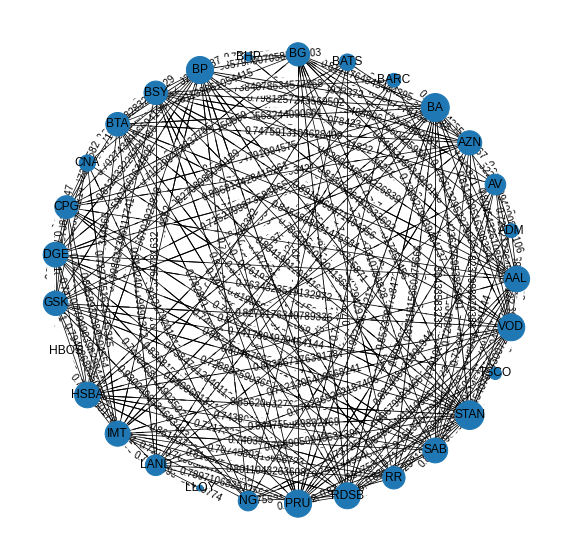

In [129]:
# timepoints = [
#     '27-04-2006', 
#     '17-05-2006', 
#     '30-05-2006', 
#     '14-06-2006', 
#     '27-06-2006', 
#     '11-07-2006',
#     '03-06-2008', 
#     '30-06-2008', 
#     '11-07-2008', 
#     '14-08-2008', 
#     '12-09-2008', 
#     '14-10-2008'
#     ]

prct.graph_plotter(Gorban_graphs[pd.to_datetime('14-10-2008', dayfirst=True)])


In [7]:
# Создаем таблицу по индексу FTSE 

ftse_df = df[df['Company'] == 'FTSEIndex'][['Date', 'Close']]
ftse_df['Date'] = pd.to_datetime(ftse_df['Date'], dayfirst=True)
ftse_df = ftse_df.set_index('Date')

# Соединям ранее подготовленные даты из correlations_df с датами 
# из ftse_df и получаем таблицу с единым набором дат
inter_index = set(ftse_df.index).intersection(set(companies_df.index))
companies_df = companies_df.loc[inter_index,:].sort_index()
ftse_df = ftse_df.loc[inter_index,:].sort_index()

# В таблице оставляем оригинальную цену ('Close') и считаем log difference
ftse_df['shift'] = ftse_df['Close'].shift(periods=1)
ftse_df['logdiff'] = np.log(ftse_df['Close']/ftse_df['shift'])
ftse_df = ftse_df.drop('shift', axis=1).dropna()

ftse_df[:5]

,Close,logdiff
Date,,
2006-01-05,5691.2,-0.004103
2006-01-06,5731.8,0.007108
2006-01-09,5731.5,-0.000052
2006-01-10,5688.8,-0.007478
2006-01-11,5731.5,0.007478


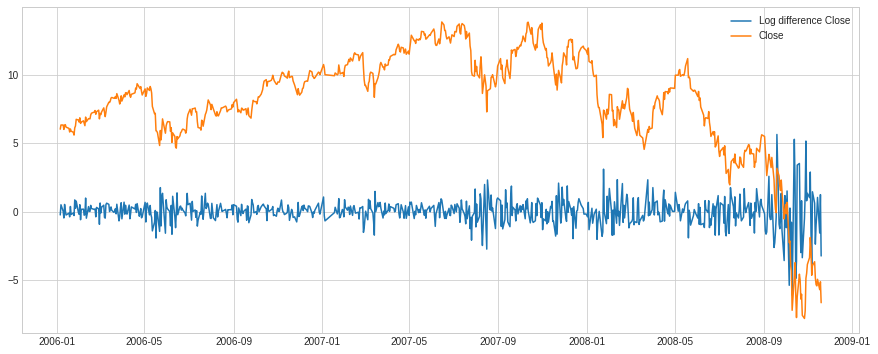

In [8]:
# Строим совместный график цены закрытия и log difference
plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(15, 6))

sc = StandardScaler()

ftse_df[['logdiff_sc']] = sc.fit_transform(ftse_df[['logdiff']])
ftse_df[['Close_sc']] = sc.fit_transform(ftse_df[['Close']])

plt.plot(ftse_df.index, ftse_df['logdiff_sc'])
plt.plot(ftse_df.index, ftse_df['Close_sc']*4+8)
plt.legend(['Log difference Close', 'Close'])
plt.show()


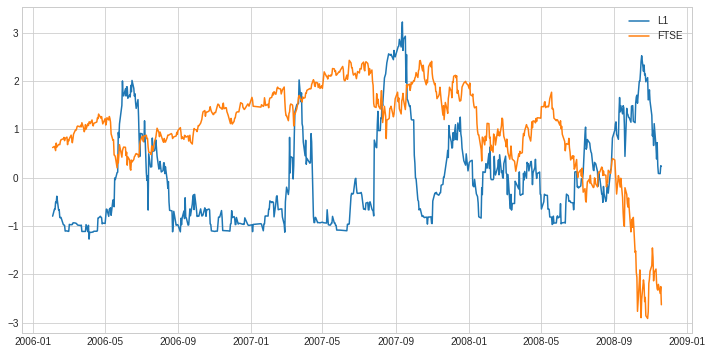

In [9]:
# Рисуем индекс FTSE и индексы графов по компаниям по Горбаню, а именно:
# - L1 
# - L2
# - strength sum
# - Dim 

variables_to_plot = [
    'L1', 
    #'L2',
    #'strength_sum',
    #'Dim_PCA'
    ]
bias = np.array(range(1+len(variables_to_plot)))

sc = StandardScaler()

gorbans_df = pd.DataFrame(np.array([gorban_chars(g) for g in list(Gorban_graphs.values())]),\
    index = list(Gorban_graphs.keys()), columns=['L1', 'L2','strength_sum','Dim_PCA'])
gorbans_df['FTSE'] = ftse_df['Close']
gorbans_df[gorbans_df.columns] = sc.fit_transform(gorbans_df[gorbans_df.columns])

plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(12, 6))

for col, num in zip(variables_to_plot + ['FTSE'], bias):
    plt.plot(gorbans_df.index, gorbans_df[col] + num)
plt.legend(labels=variables_to_plot + ['FTSE'])
plt.show()

# f, ax = plt.subplots(figsize=(9, 6))
# for col in gorbans_df.columns:
#     plt.plot(gorbans_df.index, gorbans_df[col])
# plt.legend(labels=gorbans_df.columns)
# plt.show()

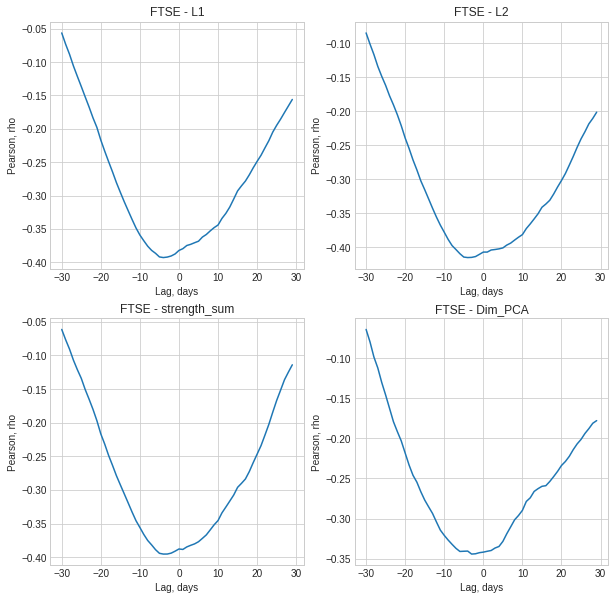

In [10]:
# Рассчитаем кросс-корреляццию по методу, изложенному в
# https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
# Для этого нам необходимо нормализовать показатели корреляционных графом и цены, 
# а после этого рассчитать корреляции.
# 
# Мы получаем, что 


def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax, var in zip(axs.flat, \
    ['L1', 'L2', 'strength_sum', 'Dim_PCA']):
    #fig.suptitle(var + ' - ' + 'FTSE')
    corrs = [crosscorr(gorbans_df['FTSE'], gorbans_df[var], lag) for lag in range(-30, 30)]

    ax.plot(range(-30, 30), corrs)

for ax, name in zip(axs.flat, ['L1', 'L2', 'strength_sum', 'Dim_PCA']):
    ax.set(xlabel='Lag, days', ylabel='Pearson, rho')
    ax.set_title('FTSE - ' + name)


In [11]:
# Рисуем паренклитик аналогичным образом, по 
# ценам компаний. 
# Принцип иной - есть окно из N временных моментов ("Здоровые"). 
# Далее паренклитики создаются по всему временному периоду.

# Вариант 1. Каждая новая дата - новый паренклитический граф

nodes_lst = companies_df.columns
# healthy = companies_df.loc[pd.to_datetime('02-02-2006', dayfirst=True): \
#     pd.to_datetime('30-04-2006', dayfirst=True)]
healthy = companies_df.loc[pd.to_datetime('02-02-2006', dayfirst=True): \
    pd.to_datetime('30-04-2006', dayfirst=True), :].append( \
        companies_df.loc[pd.to_datetime('01-04-2007', dayfirst=True): \
    pd.to_datetime('01-07-2007', dayfirst=True), :])

idx = companies_df.index[companies_df.index > pd.to_datetime('02-02-2006', \
    dayfirst=True)]

clf = znn.Zanin(healthy, nodes_lst)
clf.fit(companies_df.loc[idx,:], idx)

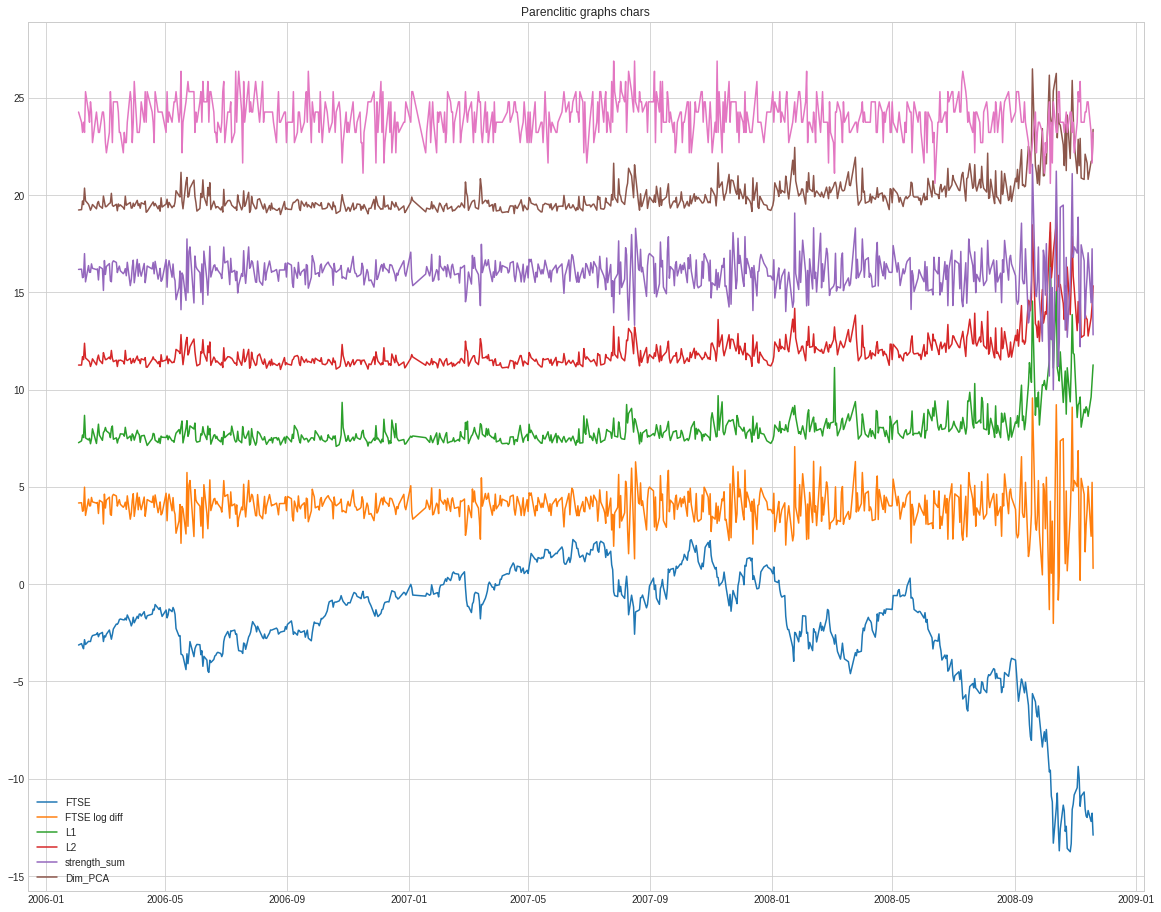

In [12]:

bias = np.array(range(1+len(variables_to_plot)))

sc = StandardScaler()

zanin_df = pd.DataFrame(np.array([gorban_chars(g) for g in list(clf.graphs.values())]),\
    index = list(clf.graphs.keys()), columns=['L1', 'L2','strength_sum','Dim_PCA'])
zanin_df['FTSE'] = ftse_df['Close']
zanin_df['FTSE log diff'] = ftse_df['logdiff']

zanin_df[zanin_df.columns] = sc.fit_transform(zanin_df[zanin_df.columns])

plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(20, 16))
plt.plot(zanin_df.index, zanin_df['FTSE']*3 -2)
plt.plot(zanin_df.index, zanin_df['FTSE log diff'] + 4)
plt.plot(zanin_df.index, zanin_df['L1'] + 8)
plt.plot(zanin_df.index, zanin_df['L2'] + 12)
plt.plot(zanin_df.index, zanin_df['FTSE log diff'] + 16)
plt.plot(zanin_df.index, zanin_df['strength_sum'] + 20)
plt.plot(zanin_df.index, zanin_df['Dim_PCA'] + 24)
plt.legend(labels=['FTSE', 'FTSE log diff','L1', 'L2', 'strength_sum', 'Dim_PCA'])
plt.title('Parenclitic graphs chars')
plt.show()


In [13]:
# # Оцениваем, какое стандартное отклонение имелось в "окнах нормальности":
# от 2-2-2006 - 01-05-2006, а также 01-04-2007 - 15-06-2007. Желательно
# использовать те окна, где мы обучали
#
# Начинаем считать это отклонение неким порогом
#
# Используем некую функцию так, что при превышении порога функция принимает значение x по модулю,
# при нахождении внутри порога - 0
# Так как значения нормализованные - должно сработать.

def broken_relu(series, thres):
    return([abs(x) if x > thres else 0 for x in series])

thres = zanin_df.loc[:pd.to_datetime('01-05-2006', dayfirst=True), 'FTSE log diff'].std() 
print(thres)

thres = zanin_df.loc[:pd.to_datetime('01-05-2006', dayfirst=True), 'FTSE log diff']\
    .append(zanin_df.loc[pd.to_datetime('01-04-2007', dayfirst=True):\
        pd.to_datetime('15-06-2007', dayfirst=True), 'FTSE log diff'])\
        .std() 
print(thres)

for col in ['L1', 'L2', 'strength_sum', 'Dim_PCA']:
    zanin_df[col + '_brl'] = broken_relu(zanin_df[col], thres)


0.3952287518930503
0.40313981868278076


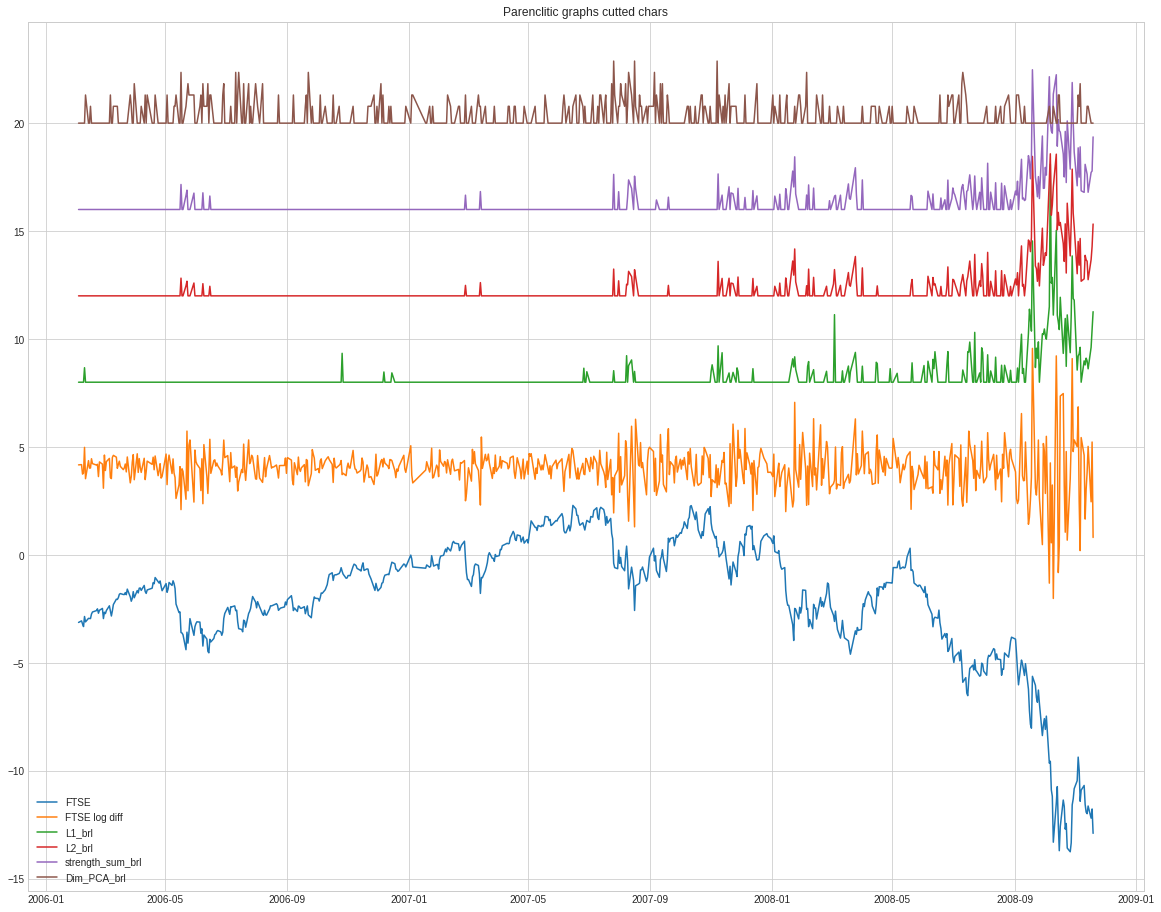

In [14]:
plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(20, 16))
plt.plot(zanin_df.index, zanin_df['FTSE']*3 -2)
plt.plot(zanin_df.index, zanin_df['FTSE log diff'] + 4)
plt.plot(zanin_df.index, zanin_df['L1_brl'] + 8)
plt.plot(zanin_df.index, zanin_df['L2_brl'] + 12)
plt.plot(zanin_df.index, zanin_df['strength_sum_brl'] + 16)
plt.plot(zanin_df.index, zanin_df['Dim_PCA_brl'] + 20)
plt.legend(labels=['FTSE', 'FTSE log diff','L1_brl', 'L2_brl', 'strength_sum_brl', 'Dim_PCA_brl'])
plt.title('Parenclitic graphs cutted chars')
plt.show()

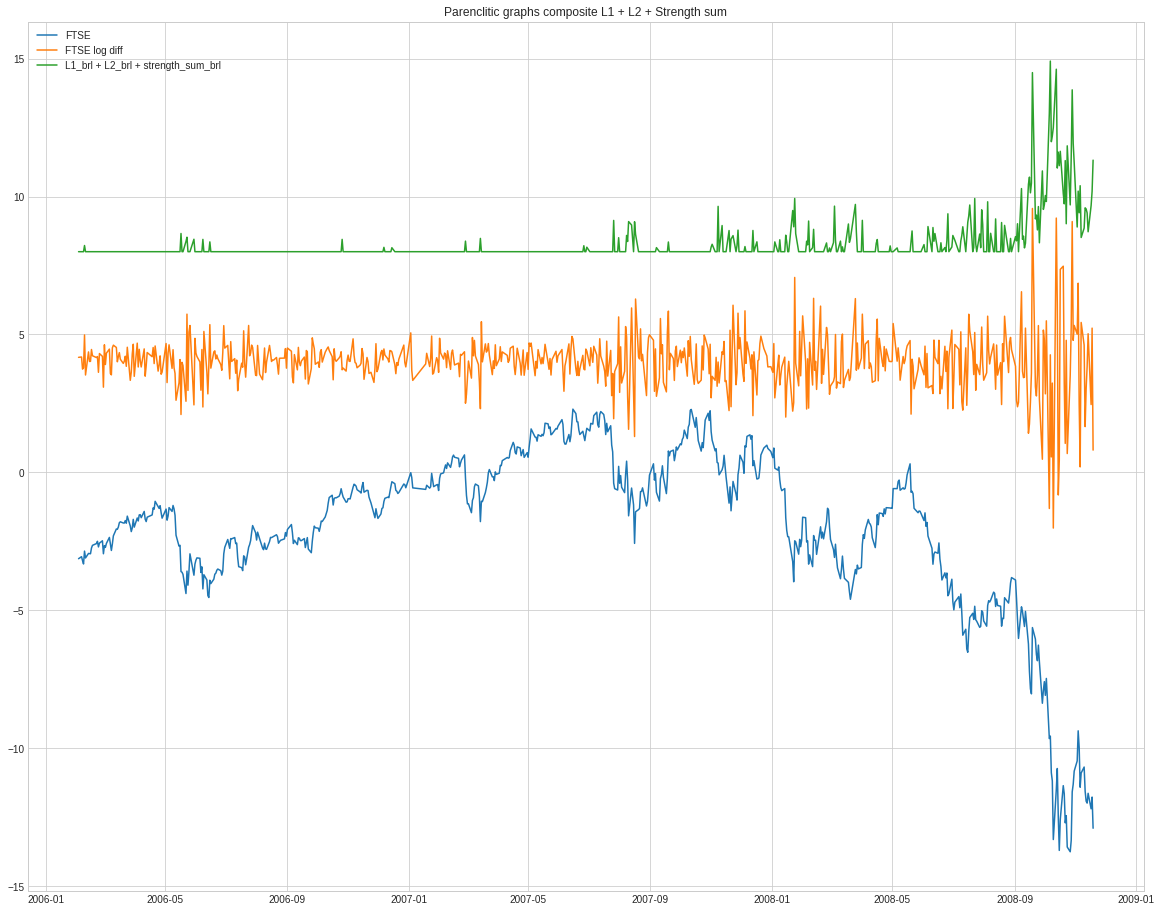

In [15]:
# Composite sum

plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(20, 16))
plt.plot(zanin_df.index, zanin_df['FTSE']*3 -2)
plt.plot(zanin_df.index, zanin_df['FTSE log diff'] + 4)
plt.plot(zanin_df.index, np.mean(zanin_df[['L1_brl', 'L2_brl', 'strength_sum_brl']], axis=1) + 8)
plt.legend(labels=['FTSE', 'FTSE log diff','L1_brl + L2_brl + strength_sum_brl'])
plt.title('Parenclitic graphs composite L1 + L2 + Strength sum')
plt.show()

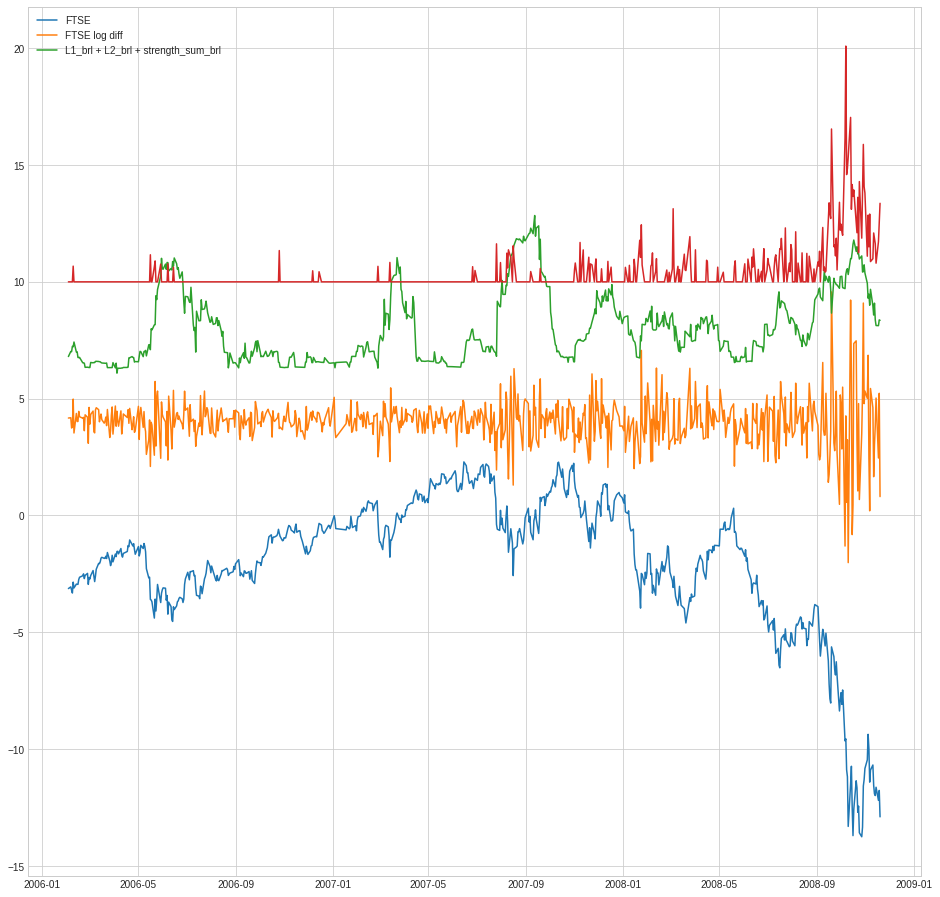

In [16]:
plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(16, 16))

plt.plot(zanin_df.index, zanin_df['FTSE']*3 -2)
plt.plot(zanin_df.index, zanin_df['FTSE log diff'] + 4)
plt.plot(gorbans_df.index, gorbans_df['L1']*1.5 + 8)
plt.plot(zanin_df.index, np.max(zanin_df[['L1_brl', 'L2_brl', 'strength_sum_brl']], axis=1) + 10)
plt.legend(labels=['FTSE', 'FTSE log diff','L1_brl + L2_brl + strength_sum_brl'])
plt.show()

prct_straight = np.max(zanin_df[['L1_brl', 'L2_brl', 'strength_sum_brl']], axis=1)

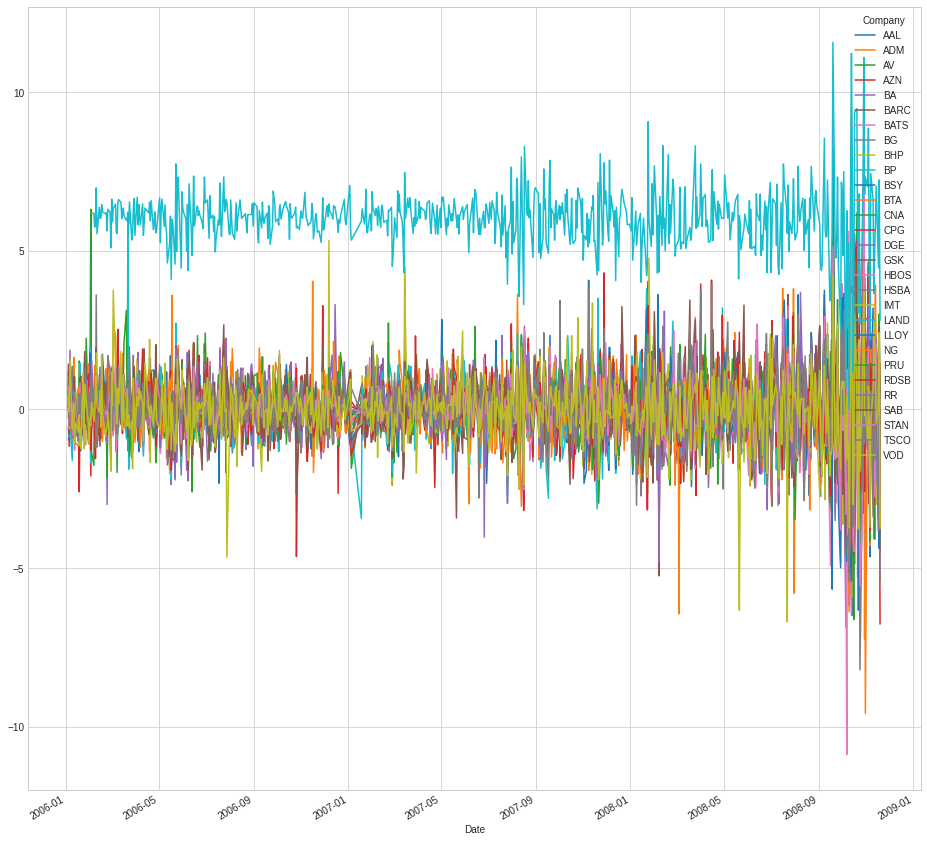

In [17]:
companies_df_sc = companies_df.copy()

companies_df_sc[companies_df.columns] = sc.fit_transform(companies_df[companies_df.columns])


f, ax = plt.subplots(figsize=(16, 16))
companies_df_sc.plot(ax = ax)#legend=None, 
plt.plot(zanin_df.index, zanin_df['FTSE log diff']+6)
plt.show()

In [18]:
# Вариант 2. Рассчитываем дисперсию из 20 предыдущих дней 
# (по версии Горбаня должна расти дисперсия). 
# 
# По окнам дисперсий обучаем паренклитики, строим графы


nodes_lst = companies_df.columns

idx = companies_df.index[companies_df.index > pd.to_datetime('02-02-2006', \
    dayfirst=True)]

test_data = pd.DataFrame()
for timepoint in idx:
    window = pd.DataFrame(companies_df.loc[companies_df.index[companies_df.index < timepoint], \
            :].tail(10).var(axis=0))
    test_data = test_data.append(window.T, ignore_index=True)

test_data.index = idx
#test_data = test_data.drop('ULVR', axis=1)
nodes_lst = test_data.columns

healthy = test_data.loc[pd.to_datetime('02-02-2006', dayfirst=True): \
    pd.to_datetime('30-04-2006', dayfirst=True), :].append( \
        test_data.loc[pd.to_datetime('01-04-2007', dayfirst=True): \
    pd.to_datetime('01-09-2007', dayfirst=True), :])

disp_clf = znn.Zanin(healthy, nodes_lst)
disp_clf.fit(test_data.loc[idx,:], idx) 

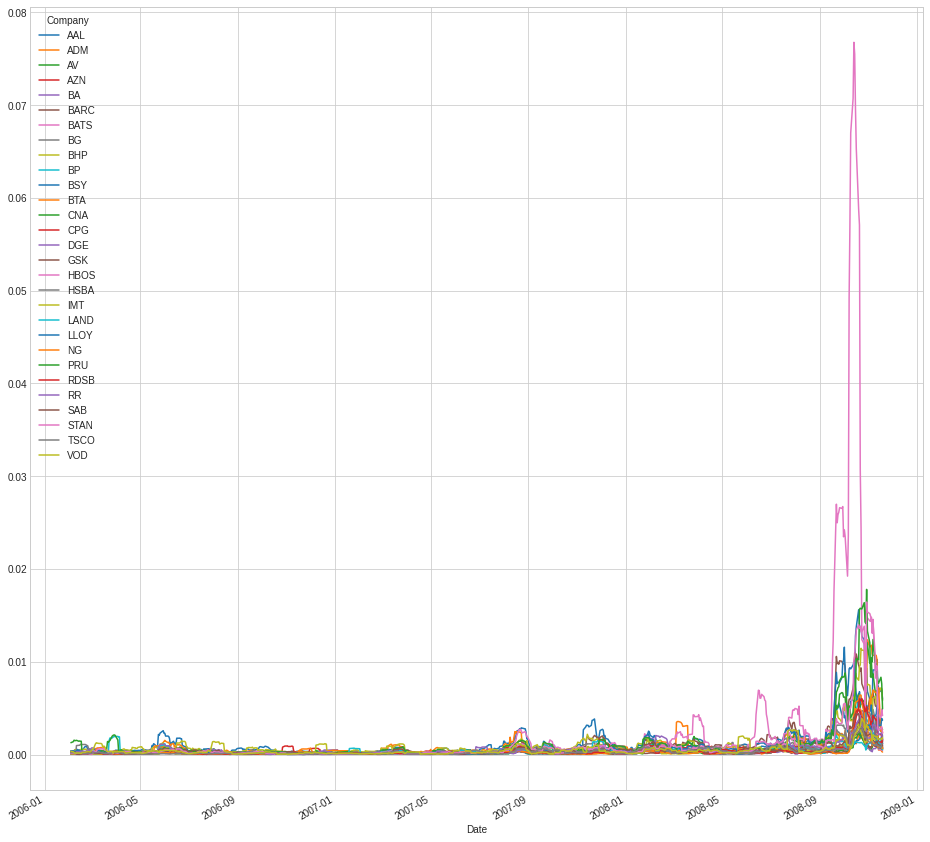

In [19]:
f, ax = plt.subplots(figsize=(16, 16))
test_data.plot(ax = ax)#legend=None, 
plt.show()

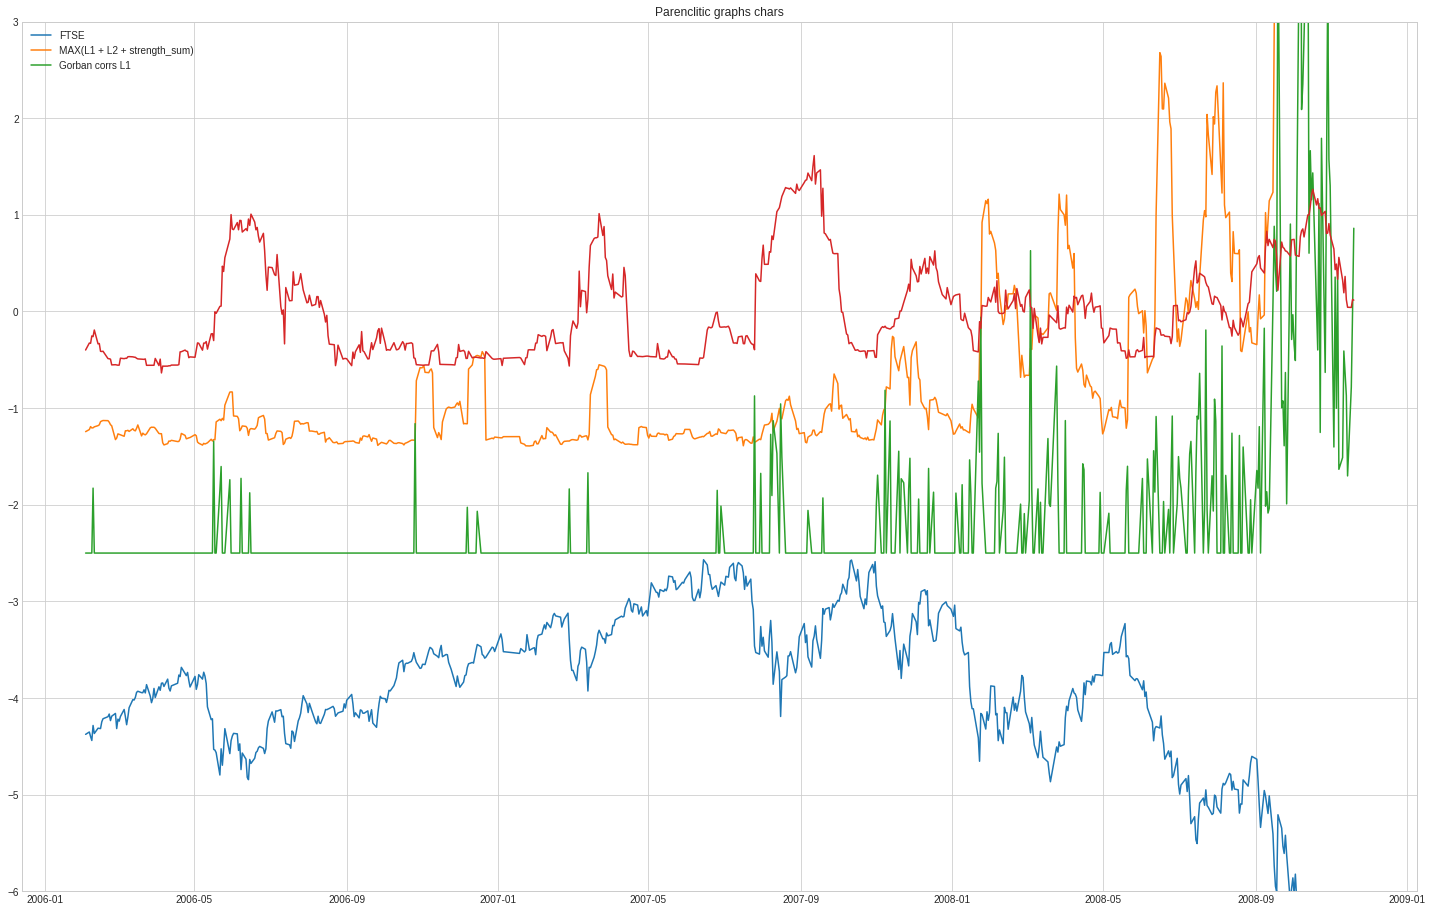

In [20]:
sc = StandardScaler()

zanin_df = pd.DataFrame(np.array([gorban_chars(g) for g in list(disp_clf.graphs.values())]),\
    index = list(disp_clf.graphs.keys()), columns=['L1', 'L2','strength_sum','Dim_PCA'])
zanin_df['FTSE'] = ftse_df['Close']
zanin_df['FTSE log diff'] = ftse_df['logdiff']

zanin_df[zanin_df.columns] = sc.fit_transform(zanin_df[zanin_df.columns])

plt.style.use('seaborn-whitegrid')
f, ax = plt.subplots(figsize=(25, 16))
plt.plot(zanin_df.index, zanin_df['FTSE']-4)
plt.plot(zanin_df.index, np.max(zanin_df[['L1', 'L2', 'strength_sum']], axis=1)*5)
plt.plot(zanin_df.index, prct_straight-2.5)

plt.plot(gorbans_df.index, gorbans_df['L1']*0.5)

plt.legend(labels=['FTSE', 'MAX(L1 + L2 + strength_sum)', 'Gorban corrs L1'])#
plt.title('Parenclitic graphs chars')
plt.ylim(-6, 3)
plt.show()
